### 1. LOADING FILES

In [1]:
import pickle 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,f1_score,confusion_matrix

In [111]:
lista_modelos=['DTC','RND','BAG','ADA','GBCT','LOGREG','KNN']

In [3]:
train=pd.read_csv('E:\Bootcamp_22\Javier\Repositorios\Machine_Learning\data\df_train.csv',sep=',')
test=pd.read_csv('E:\Bootcamp_22\Javier\Repositorios\Machine_Learning\data\df_test.csv',sep=',')
X_test=test[['Código Distrito Centro','Age_range_code','Nationality_code','Sexo_code']]
X_train=train[['Código Distrito Centro','Age_range_code','Nationality_code','Sexo_code']]
y_test=test['Código Tipo Supuesto Urgente']
y_train=train['Código Tipo Supuesto Urgente']

In [6]:
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)

(9477, 5)
(28429, 5)
(9477,)
(28429,)


In [4]:
def load_files(file):
    '''
    Cargar modelos con formato binario en un notebook o fichero python
    '''
    os.chdir('E:\Bootcamp_22\Javier\Repositorios\Machine_Learning\model')
    model = pickle.load( open( file, "rb" ) )
    return model

In [5]:
def save_files(model):
    '''
    Grabar modelos con formato binario en una carpeta
    '''
    os.chdir('E:/Bootcamp_22/Javier/Repositorios/Machine_Learning/model')
    date=str(datetime.today().strftime('%y%m%d%H%M%S'))
    name=input("Introduce el nombre del modelo a grabar (iniciales): ")
    file=name+date+'.pickle'
    pickle.dump(model,open(file,'wb'))

Aqui vamos a cargar los modelos para pasar los test

In [14]:
ADA = load_files( 'ADA220909190844.pickle' ) 
BAG = load_files( 'BAG220909190839.pickle' ) 
DTC = load_files( 'DTC220909190809.pickle' ) 
GBCT = load_files( 'GBCT220909190855.pickle' ) 
RND = load_files( 'RND220909190829.pickle' ) 

### 2. CALCULATING ERROR IN EACH MODEL

In [12]:
def error_modelo(model, x_test, Y_test):
    '''
    Dejamos grabada cada uno de los parámetros de cada modelo y hacemos su representación
    '''
    y_pred = model.predict(X_test)
    f1_model=f1_score(y_test, y_pred,average='macro')
    acc_model=accuracy_score(y_test, y_pred)
    precision_model=precision_score(y_test, y_pred,average='macro')
    recall_model=recall_score(y_test, y_pred,average='macro')
    roc_auc_model=roc_auc_score(y_test, model.predict_proba(X_test),multi_class='ovr')
    conf_model=confusion_matrix(y_test, y_pred, normalize='true')
    model_error = {'accuracy': acc_model, 'f-1': f1_model, 'recall': recall_model , 'precision': precision_model}
    print(model_error)
    df=pd.DataFrame.from_dict(model_error,orient='index')
    print('Accuracy', acc_model)
    print('F1', f1_model)
    print('Precision', precision_model)
    print('Recall', recall_model)
    print('-'*30)
    print('ROC', roc_auc_model)

    plt.figure(figsize=(10,10))
    sns.heatmap(conf_model, annot=True)
    return df

### 3. LOOKING FOR THE BEST MODEL

**ADA**

In [16]:
ada_params = {
    'n_estimators': np.arange(1,200,50),                                # hacerlo o mano y ver si consigo mejores resultados
    'learning_rate': np.arange(0.01,0.1,0.02),
    'algorithm': ['SAMME','SAMME.R']   
}

GS_ADA = GridSearchCV(estimator = ADA,
                  param_grid = ada_params,
#                  n_jobs = -1,              #Cuantos procesadores se utilizan, -1 es el maximo
                  cv = 5,
                  scoring='f1_macro',
#                  error_score='raise'
                    )

GS_ADA.fit(X_train, y_train)
print(GS_ADA.best_estimator_)
print(GS_ADA.best_score_)
print(GS_ADA.best_params_)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=10,
                                                         random_state=20),
                   learning_rate=0.01, n_estimators=1, random_state=20)
0.4452497439698043
{'algorithm': 'SAMME', 'learning_rate': 0.01, 'n_estimators': 1}


Según estos datos habría que realizar un nuevo GS modificando el parámetro *learning_rate* disminuyendo el rango.

In [17]:
save_files(GS_ADA.best_estimator_)

{'accuracy': 0.7604308390022676, 'f-1': 0.4438933484920403, 'recall': 0.45284560054056466, 'precision': 0.43572527681231643}
Accuracy 0.7604308390022676
F1 0.4438933484920403
Precision 0.43572527681231643
Recall 0.45284560054056466
------------------------------
ROC 0.6696154813173864


,ADA
accuracy,0.760431
f-1,0.443893
recall,0.452846
precision,0.435725


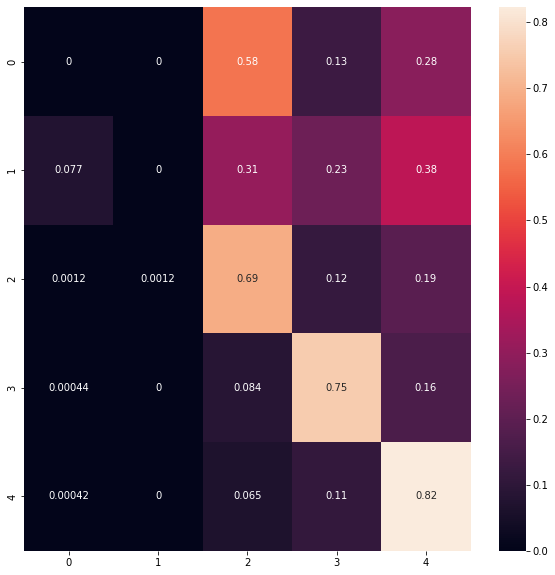

In [18]:
df_GS_ADA= error_modelo(GS_ADA.best_estimator_, X_test, y_test)
df_GS_ADA.columns=['ADA']
df_GS_ADA

**BAG**

In [19]:
bag_params = {
    'bootstrap': [True,False],                              # hacerlo o mano y ver si consigo mejores resultados
    'warm_start': [True,False],
    'max_features': np.arange(3,5,1),
    'max_samples': np.arange(125,175,25),
    'n_estimators': np.arange(125,175,25)
}

GS_BAG = GridSearchCV(estimator = BAG,
                  param_grid = bag_params,
#                  n_jobs = -1,              #Cuantos procesadores se utilizan, -1 es el maximo
                  cv = 5,
                  scoring='f1_micro')

GS_BAG.fit(X_train, y_train)
print(GS_BAG.best_estimator_)
print(GS_BAG.best_score_)
print(GS_BAG.best_params_)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                        random_state=20),
                  max_features=4, max_samples=150, n_estimators=125,
                  random_state=20, warm_start=True)
0.7592592592592592
{'bootstrap': True, 'max_features': 4, 'max_samples': 150, 'n_estimators': 125, 'warm_start': True}


Estos parámetros son válidos como valores de optimización.

Se podría mejorar acotando más aún los mismos.

In [20]:
save_files(GS_BAG.best_estimator_)

c:\Users\jtr_7\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.7626984126984127, 'f-1': 0.4461822879182811, 'recall': 0.4562989790832897, 'precision': 0.43714004813392293}
Accuracy 0.7626984126984127
F1 0.4461822879182811
Precision 0.43714004813392293
Recall 0.4562989790832897
------------------------------
ROC 0.8124244869011783


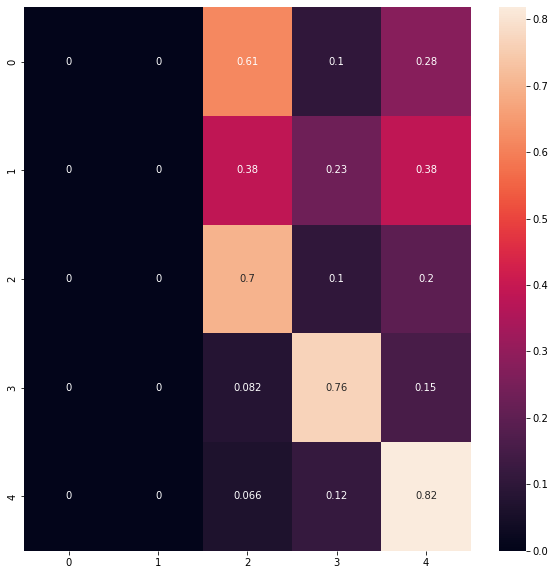

In [21]:
df_GS_BAG = error_modelo(GS_BAG.best_estimator_, X_test, y_test)
df_GS_BAG.columns=['BAG']

**DTC**

In [22]:
DTC_params = {
#    'max_leaf_nodes': np.arange(1,50,5),                    # hacerlo o mano y ver si consigo mejores resultados
    'criterion': ['gini','entropy'],
    'max_depth': np.arange(1,5,1),
    'max_features': np.arange(3,5,1),
    'min_samples_leaf': np.arange(0.05,0.15,0.05),
    'min_samples_split': np.arange(3,7,1)
}

GS_DTC = GridSearchCV(estimator = DTC,
                  param_grid = DTC_params,
#                  n_jobs = -1,              #Cuantos procesadores se utilizan, -1 es el maximo
                  cv = 3,
                  scoring='f1_micro')

GS_DTC.fit(X_train, y_train)
print(GS_DTC.best_estimator_)
print(GS_DTC.best_score_)
print(GS_DTC.best_params_)

DecisionTreeClassifier(max_depth=3, max_features=3, min_samples_leaf=0.05,
                       min_samples_split=3, random_state=20)
0.7401360544217687
{'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 0.05, 'min_samples_split': 3}


In [23]:
save_files(GS_DTC.best_estimator_)

c:\Users\jtr_7\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.7417233560090702, 'f-1': 0.43573349331328065, 'recall': 0.45590530165782184, 'precision': 0.42351130015477}
Accuracy 0.7417233560090702
F1 0.43573349331328065
Precision 0.42351130015477
Recall 0.45590530165782184
------------------------------
ROC 0.7707881528706151


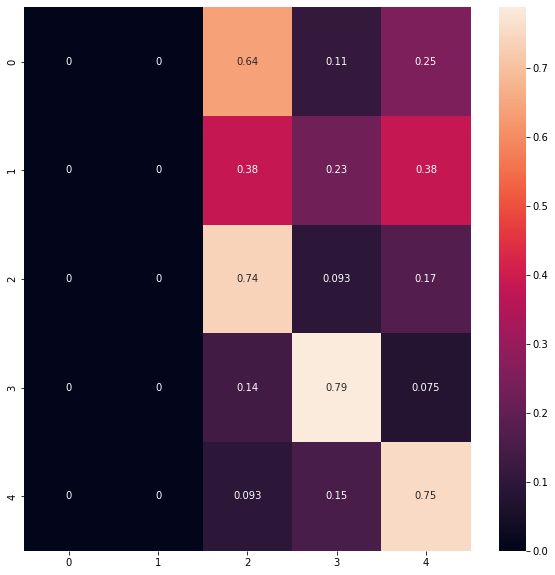

In [24]:
df_GS_DTC = error_modelo(GS_DTC.best_estimator_, X_test, y_test)
df_GS_DTC.columns=['DTC']

**RND**

In [25]:
random_forest_params = {                            # pendiente de volver a realizarlo
    'max_leaf_nodes': [5,6,7],
#    'criterion': ['gini','entropy'],
    'max_depth': [2,3,4],
    'max_features': [3,4],
#    'min_samples_leaf': [0.05,0.1,0.15],
#    'bootstrap': [True,False],
#    'warm_start': [True,False],
    'min_samples_split': [2 ,5,15,20]
}

GS_RND = GridSearchCV(estimator = RND,
                  param_grid = random_forest_params,
#                  n_jobs = -1,              #Cuantos procesadores se utilizan, -1 es el maximo
                  cv = 3,
#                  error_score='raise',
                  scoring='f1_micro')

GS_RND.fit(X_train, y_train)
print(GS_RND.best_estimator_)
print(GS_RND.best_score_)
print(GS_RND.best_params_)

RandomForestClassifier(max_depth=4, max_features=3, max_leaf_nodes=7,
                       random_state=20)
0.7540060468631897
{'max_depth': 4, 'max_features': 3, 'max_leaf_nodes': 7, 'min_samples_split': 2}


In [26]:
save_files(GS_RND.best_estimator_)

c:\Users\jtr_7\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.7600907029478458, 'f-1': 0.4459616477709239, 'recall': 0.4588037861762695, 'precision': 0.435364970761944}
Accuracy 0.7600907029478458
F1 0.4459616477709239
Precision 0.435364970761944
Recall 0.4588037861762695
------------------------------
ROC 0.8086826490993506


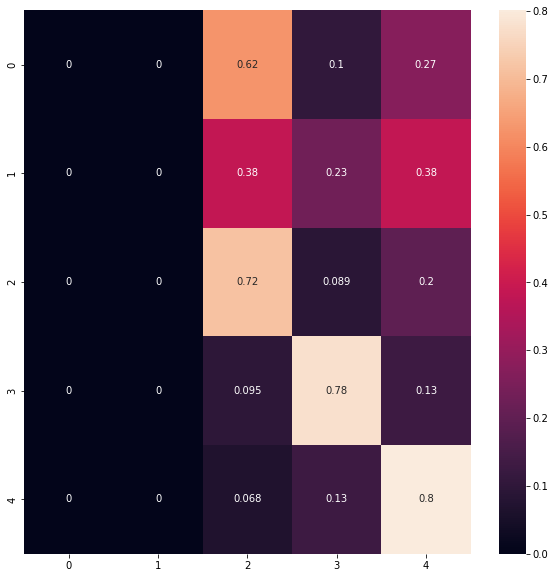

In [27]:
df_GS_RND = error_modelo(GS_RND.best_estimator_, X_test, y_test)
df_GS_RND.columns=['RND']

**GBCT**


QUEDA ESTE MODELO POR MEJORAR

In [29]:
GB_params = {                                                                       # He reducido cantiddad de valores para repetirlo y ver si lo hace 
#    'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],
    'max_depth': np.arange(1,11,5),
    'warm_start': [True, False],
    'max_features': np.arange(2,5,2),
    'learning_rate': np.arange(0.05,0.55,0.25),
    'min_samples_split': np.arange(5,30,10),
    'n_estimators': np.arange(100,200,50)
}

GS_GBCT = GridSearchCV(estimator = GBCT,
                  param_grid = GB_params,
#                  n_jobs = -1,              #Cuantos procesadores se utilizan, -1 es el maximo
                  error_score='raise',
                  cv = 3,
                  scoring='f1_micro')

GS_GBCT.fit(X_train, y_train)
print(GS_GBCT.best_estimator_)
print(GS_GBCT.best_score_)
print(GS_GBCT.best_params_)

GradientBoostingClassifier(learning_rate=0.05, max_depth=6, max_features=4,
                           min_samples_split=25, random_state=20,
                           warm_start=True)
0.759297052154195
{'learning_rate': 0.05, 'max_depth': 6, 'max_features': 4, 'min_samples_split': 25, 'n_estimators': 100, 'warm_start': True}


In [30]:
save_files(GS_GBCT.best_estimator_)

c:\Users\jtr_7\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.7639455782312925, 'f-1': 0.44683358697079056, 'recall': 0.45602468430665777, 'precision': 0.43841515047852225}
Accuracy 0.7639455782312925
F1 0.44683358697079056
Precision 0.43841515047852225
Recall 0.45602468430665777
------------------------------
ROC 0.820903499735917


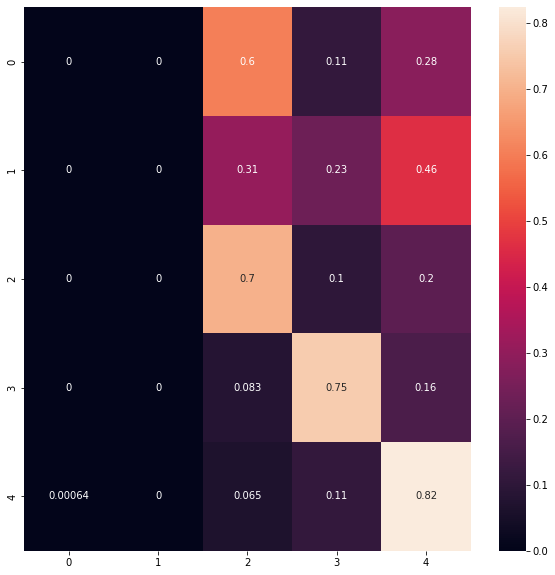

In [31]:
df_GS_GBCT = error_modelo(GS_GBCT.best_estimator_, X_test, y_test)
df_GS_GBCT.columns=['GBCT']

Salvo el modelo **ADA Boost** ninguno de los modelos mejora con un *GridSearch*, es por ello que vamos a hacer un último intento de mejorar los modelos "a mano".

In [32]:
df_errores=pd.concat([df_GS_ADA,df_GS_BAG,df_GS_DTC,df_GS_RND,df_GS_GBCT],axis=1)
df_errores

,ADA,BAG,DTC,RND,GBCT
accuracy,0.760431,0.762698,0.741723,0.760091,0.763946
f-1,0.443893,0.446182,0.435733,0.445962,0.446834
recall,0.452846,0.456299,0.455905,0.458804,0.456025
precision,0.435725,0.437140,0.423511,0.435365,0.438415
